## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Perform camera calibration

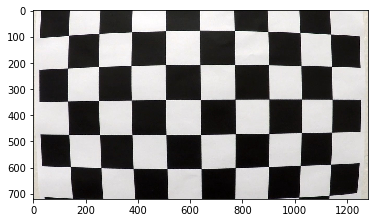

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#display first camera calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

---
The calbration images are read from the camera_cal folder, are transformed to grayscale and the chessboard corners are extracted from each image. If the corners are found correctly (ret == true), their coordinates are appended to the array imgpoints. At the same time the location of the undistorted chessboard corners is appended to the array objpoints. These are the same for each image. Once the data from all images is collected the function calibrateCamera is used to compute the camera matrix mtx (focal length and location of image center) and the distortion coefficients dist for the used camera. These coefficients can then be used to get undistorted camera images. Several images are required during the calibration process to make the optimization more robust.

In [2]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(2000)

# Compute calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

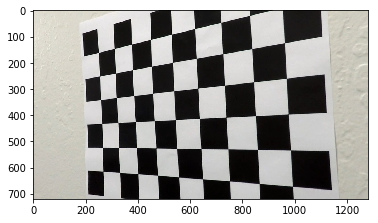

In [3]:
# Apply calibration to test image
img = mpimg.imread('./camera_cal/calibration4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

## Define image processing class
The image processing class holds all functions that are used to process the images in the later sections of this notebook. These are the following:
- ini_tform: load camera specific information (transformation matrix, etc.) into class
- load image: load a new image into class
- undistort: use the camera coefficients to get an undistorted camera image
- ptransform: transform camera image into top-down view
- grayscale: convert to grayscale
- gaussian blur: apply gaussian blur filter
- canny: gradient based feature extraction
- region_of_interest: select region of interest from camera image
- hough: fit lines through the features detected with canny; this function includes a kalman filter that can be used to make the fit more robust by using information from previous frames (e.g. from a video).
- cg_thresh: image enhanmencement for better lane detection (used methods: gradiend and hls transform)
- find_lanes_1: compute lane lines from enhanced image
- draw_lanes: overlay lane lines in original image frame
- col_test: test function for different image enhancement methods

In [4]:
import math
from numpy.linalg import inv
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from skimage import exposure

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def bound(min,max,input):
    if(input > max):
        output = max
    elif(input < min):
        output = min
    else:
        output = input
    return output

class imgproc:
    def __init__(self,img):
        #image parameters
        self.img = img
        self.orig = img
        self.thresh = np.zeros_like(img)
        self.warped = np.zeros_like(img)
        #camera parameters
        self.mtx = [] #camera matrix (focal length and image center)
        self.dist = [] #lens distortion coefficients
        self.M = [] # perspective transformation matrix
        self.Minv = [] # inverse perspective transformation matrix
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        #lane detection parameters
        self.detected = [False,False] # was the line detected in the last iteration?
        #self.recent_xfitted = [] # x values of the last n fits of the line
        #self.bestx = None # average x values of the fitted line over the last n iterations
        self.best_fit = np.array([[0,0,0],[0,0,0]],dtype=np.float) # polynomial coefficients averaged over the last n iterations
        self.current_fit = np.array([[0,0,0],[0,0,0]],dtype=np.float) # polynomial coefficients for the most recent fit
        self.fit_list_l = np.ndarray(shape=(5,1,3),dtype=np.float)
        self.fit_list_r = np.ndarray(shape=(5,1,3),dtype=np.float)
        self.radius_of_curvature = [None,None] # radius of curvature of the line in some units
        #self.line_base_pos = [None,None] # distance in meters of vehicle center from the line
        self.diffs = np.array([[0,0,0],[0,0,0]], dtype=np.float) # difference in fit coefficients between last and new fits
        self.reaquire = [True,True]
        self.allx = None # x values for detected line pixels
        self.ally = None # y values for detected line pixels
        self.ecnt = [0.,0.]
        self.center_pos = 0.
        
    def ini_tform(self,mtx,dist,M,Minv):
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.Minv = Minv
        
    def load_image(self,img):
        self.img = img
        self.orig = img
        
    def undistort(self):
        self.img = cv2.undistort(self.img, self.mtx, self.dist, None, self.mtx)
        
    def ptransform(self):
        self.img = cv2.warpPerspective(self.img, self.M, (self.img.shape[1],self.img.shape[0]), flags=cv2.INTER_LINEAR)
        self.warped = cv2.warpPerspective(self.orig, self.M, (self.img.shape[1],self.img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def grayscale(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        
    def gaussian_blur(self,kernel_size):
        self.img = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 0)
    
    def canny(self,low_threshold, high_threshold):
        self.img = cv2.Canny(self.img, low_threshold, high_threshold)
        
    def region_of_interest(self, vertices):
        #defining a blank mask to start with
        mask = np.zeros_like(self.img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(self.img.shape) > 2:
            channel_count = self.img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        self.img = cv2.bitwise_and(self.img, mask)

    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        color=[255, 0, 0]
        thickness=5
        bound_ll = -0.85 #left lane gradient lower boundary
        bound_lu = -0.55 #left lane gradient upper boundary
        bound_rl =  0.45 #right lane gradient lower boundary
        bound_ru =  0.75 #right lane gradient upper boundary
        lines = cv2.HoughLinesP(self.img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((self.img.shape[0], self.img.shape[1], 3), dtype=np.uint8)
                
        m_seg_l = np.array([]) #gradient of left line segment
        b_seg_l = np.array([]) #offset of left line segment
        len_seg_l = np.array([]) #length of left line segment
        m_seg_r = np.array([])
        b_seg_r = np.array([])
        len_seg_r = np.array([])
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), [0,255,0], 5)
                m = (y2-y1)/(x2-x1) #gradient of line segment
                b = y1-m*x1 #offset of line segment
                #sort for left and right line
                if(bound_ll < m < bound_lu):
                    m_seg_l = np.append(m_seg_l,m)
                    b_seg_l = np.append(b_seg_l,b)
                    len_seg_l = np.append(len_seg_l,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
                elif(bound_rl < m < bound_ru):
                    m_seg_r = np.append(m_seg_r,m)
                    b_seg_r = np.append(b_seg_r,b)
                    len_seg_r = np.append(len_seg_r,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
    
        #compute weighted average (by segment length) for gradient and offset
        b_l = 0
        b_r = 0
        m_l  = 0
        m_r  = 0
        for i in range (len(len_seg_l)):
            length = np.sum(len_seg_l)
            m_l = m_l + m_seg_l[i]*len_seg_l[i]/length
            b_l = b_l + b_seg_l[i]*len_seg_l[i]/length
        for i in range (len(len_seg_r)):
            length = np.sum(len_seg_r)
            m_r = m_r + m_seg_r[i]*len_seg_r[i]/length
            b_r = b_r + b_seg_r[i]*len_seg_r[i]/length
        
        #apply filter for gradient and offset and plot line
        y1 = int(self.img.shape[0]*2/3)
        y2 = int(self.img.shape[0])
        cv2.line(line_img, (int((y1-b_l)/m_l), y1), (int((y2-b_l)/m_l), y2), [255,0,0], 10)
        cv2.line(line_img, (int((y1-b_r)/m_r), y1), (int((y2-b_r)/m_r), y2), [255,0,0], 10)
        
        return line_img, m_l, b_l, m_r, b_r

    def weighted_img(self, img, α=0.8, β=1., λ=0.):
        self.img = cv2.addWeighted(self.orig, α, img, β, λ)
        
    def cg_thresh(self,s_thresh = (20,120),m_thresh=(60,120),d_thresh = (0.7,1.3),h_thresh = (100, 250)):
        sobel_kernel = 3
        
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        
        scaled_absx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        gradx = np.zeros_like(scaled_absx)
        gradx[(scaled_absx >= s_thresh[0]) & (scaled_absx <= s_thresh[1])] = 1
        
        #scaled_absy = np.uint8(255*abs_sobely/np.max(abs_sobely))
        #grady = np.zeros_like(scaled_absy)
        #grady[(scaled_absy >= s_thresh[0]) & (scaled_absy <= s_thresh[1])] = 1
        
        mag = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled_mag = np.uint8(255*mag/np.max(mag))
        mag_binary = np.zeros_like(scaled_mag)
        mag_binary[(scaled_mag >= m_thresh[0]) & (scaled_mag <= m_thresh[1])] = 1

        dirs = np.arctan2(abs_sobely, abs_sobelx)
        dir_binary = np.zeros_like(dirs)
        dir_binary[(dirs >= d_thresh[0]) & (dirs <= d_thresh[1])] = 1
        
        hls = cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        hls_binary = np.zeros_like(S)
        hls_binary[(S > h_thresh[0]) & (S <= h_thresh[1])] = 1

        combined = np.zeros_like(dir_binary)
        #combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
        combined[((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
                
        self.img = combined
        
        self.thresh = np.zeros_like(self.orig)
        #self.thresh[(gradx == 1)] = [255,0,0]
        self.thresh[(mag_binary == 1) & (dir_binary == 1)] = [0,255,0]
        self.thresh[(hls_binary == 1)] = [0,0,255]               
        
    def find_lanes_1(self, pcheck=1):
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(self.img.shape[0]/nwindows)
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 100
        # Pixel boundaries for "anchoring" lanes at image bottom
        b_l = [150,400]
        b_r = [1000,1200]
        
        # Take a histogram of the bottom half of the (previously thresholded and warped) image
        histogram = np.sum(self.img[np.int(self.img.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
                
        if(self.reaquire[0]==True):
            #leftx_base = np.argmax(histogram[:midpoint])
            leftx_base = np.argmax(histogram[b_l[0]:b_l[1]])+b_l[0]
            leftx_current = leftx_base
            left_lane_inds = []
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = self.img.shape[0] - (window+1)*window_height
                win_y_high = self.img.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds = np.concatenate(left_lane_inds)
        else:
            left_lane_inds = ((nonzerox > ((self.best_fit[0][0]*((nonzeroy*self.ym_per_pix)**2) + self.best_fit[0][1]*(nonzeroy*self.ym_per_pix) + self.best_fit[0][2])/self.xm_per_pix - margin)) &\
                              (nonzerox < ((self.best_fit[0][0]*((nonzeroy*self.ym_per_pix)**2) + self.best_fit[0][1]*(nonzeroy*self.ym_per_pix) + self.best_fit[0][2])/self.xm_per_pix + margin)))
            
        if(self.reaquire[1]==True):
            #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            rightx_base = np.argmax(histogram[b_r[0]:b_r[1]])+b_r[0]
            rightx_current = rightx_base
            right_lane_inds = []
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = self.img.shape[0] - (window+1)*window_height
                win_y_high = self.img.shape[0] - window*window_height
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds = np.concatenate(right_lane_inds)
        else:
            right_lane_inds = ((nonzerox > ((self.best_fit[1][0]*((nonzeroy*self.ym_per_pix)**2) + self.best_fit[1][1]*(nonzeroy*self.ym_per_pix) + self.best_fit[1][2])/self.xm_per_pix - margin)) &\
                               (nonzerox < ((self.best_fit[1][0]*((nonzeroy*self.ym_per_pix)**2) + self.best_fit[1][1]*(nonzeroy*self.ym_per_pix) + self.best_fit[1][2])/self.xm_per_pix + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        self.allx = np.array([leftx,rightx])
        self.ally = np.array([lefty,righty])
        
        # Fit a second order polynomial to each
        self.current_fit[0] = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.current_fit[1] = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        
        yc = self.img.shape[0]*self.ym_per_pix
        curvrad_l = (1+(2*self.current_fit[0][0]*yc+self.current_fit[0][1])**2)**(3/2)/np.absolute(2*self.current_fit[0][0])
        curvrad_r = (1+(2*self.current_fit[1][0]*yc+self.current_fit[1][1])**2)**(3/2)/np.absolute(2*self.current_fit[1][0])
        xc_l = (self.current_fit[0][0]*(yc**2) + self.current_fit[0][1]*yc + self.current_fit[0][2])/self.xm_per_pix
        xc_r = (self.current_fit[1][0]*(yc**2) + self.current_fit[1][1]*yc + self.current_fit[1][2])/self.xm_per_pix
        
        # Plausibility checks
        ### if plausibility ok then add current fit to fit_list
        if(pcheck==1):
            cond1 = np.abs(curvrad_l-curvrad_r)<500
            cond2_l = (b_l[0] <= int(xc_l) <= b_l[1])
            cond2_r = (b_r[0] <= int(xc_r) <= b_r[1])
            cond3_l = (np.abs(curvrad_l) > 300)
            cond3_r = (np.abs(curvrad_r) > 300)
            if(cond1 & cond2_l & cond3_l):
                self.detected[0]=True
                self.ecnt[0] = bound(0.,5.,self.ecnt[0]-1.)
            else:
                self.detected[0]=False
                self.ecnt[0] = bound(0.,5.,self.ecnt[0]+1.)
                
            if(cond1 & cond2_r & cond3_r):
                self.detected[1]=True
                self.ecnt[1] = bound(0.,5.,self.ecnt[1]-1.)
            else:
                self.detected[1]=False
                self.ecnt[1] = bound(0.,5.,self.ecnt[1]+1.)
        else:
            self.detected=[True,True]
            self.ecnt=[0.,0.]
            
        if(self.ecnt[0] == 5.):
            self.reaquire[0]=True
        if(self.ecnt[1] == 5.):
            self.reaquire[1]=True
        
        if(self.detected[0]==True):
            if(self.reaquire[0]==True):
                self.fit_list_l=np.full_like(self.fit_list_l,self.current_fit[0])
                self.reaquire[0]=False
                self.ecnt[0]=0.
            else:
                self.fit_list_l=np.delete(self.fit_list_l,4,axis=0)
                self.fit_list_l=np.insert(self.fit_list_l,0,self.current_fit[0],axis=0)
        if(self.detected[1]==True):
            if(self.reaquire[1]==True):
                self.fit_list_r=np.full_like(self.fit_list_r,self.current_fit[1])
                self.reaquire[1]=False
                self.ecnt[1]=0.
            else:
                self.fit_list_r=np.delete(self.fit_list_r,4,axis=0)
                self.fit_list_r=np.insert(self.fit_list_r,0,self.current_fit[1],axis=0)
        self.best_fit=np.concatenate((self.fit_list_l.sum(axis=0)/5,self.fit_list_r.sum(axis=0)/5),axis=0)
        
        self.radius_of_curvature[0] = (1+(2*self.current_fit[0][0]*yc+self.current_fit[0][1])**2)**(3/2)/np.absolute(2*self.current_fit[0][0])
        self.radius_of_curvature[1] = (1+(2*self.current_fit[1][0]*yc+self.current_fit[1][1])**2)**(3/2)/np.absolute(2*self.current_fit[1][0])
        xc_lb = (self.best_fit[0][0]*(yc**2) + self.best_fit[0][1]*yc + self.best_fit[0][2])/self.xm_per_pix
        xc_rb = (self.best_fit[1][0]*(yc**2) + self.best_fit[1][1]*yc + self.best_fit[1][2])/self.xm_per_pix
        self.center_pos = ((xc_lb+xc_rb)/2-self.img.shape[1]/2)*self.xm_per_pix
                
    def draw_lanes(self):
        ploty = np.linspace(0, self.img.shape[0]-1, self.img.shape[0])*self.ym_per_pix
        left_fitx = (self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2])/self.xm_per_pix
        right_fitx = (self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2])/self.xm_per_pix
        ploty = ploty/self.ym_per_pix
        
        # draw warped image
        self.warped[self.ally[0], self.allx[0]] = [255,0,0]
        self.warped[self.ally[1], self.allx[1]] = [0,0,255]
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img.shape[1], self.img.shape[0])) 
        # Combine the result with the original image
        self.img = cv2.addWeighted(self.orig, 1, newwarp, 0.3, 0)
        
        image1 = Image.fromarray(self.img)
        image2 = Image.fromarray(self.thresh)
        image3 = Image.fromarray(self.warped)

        draw = ImageDraw.Draw(image1,'RGB')
        font = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', size=40)
        draw.text((20,30),  'Curverad_l: '+str(self.radius_of_curvature[0]), fill=(255, 255, 255), font=font)
        draw.text((20,80),  'Curverad_r: '+str(self.radius_of_curvature[1]), fill=(255, 255, 255), font=font)
        draw.text((20,130), 'Pos from center: '+str(self.center_pos), fill=(255, 255, 255), font=font)

        image2=image2.resize((640,360),Image.ANTIALIAS)
        image3=image3.resize((640,360),Image.ANTIALIAS)

        result = Image.new('RGB',(image1.size[0]+image2.size[0],image1.size[1]))
        result.paste(im=image1, box=(0, 0))
        result.paste(im=image2, box=(image1.size[0], 0))
        result.paste(im=image3, box=(image1.size[0], image2.size[1]))
        self.img = np.array(result)
        
    def col_test(self, sel_method=0, s_thresh=100, v_thresh=200):
        hls=cv2.cvtColor(self.orig, cv2.COLOR_RGB2HLS)
        hsv=cv2.cvtColor(self.orig, cv2.COLOR_RGB2HSV)
        if(sel_method==0):
            self.img=hls
        elif(sel_method==1):
            self.img=hsv
        elif(sel_method==2):
            self.img=np.dstack((hls[:,:,0],hls[:,:,0],hls[:,:,0]))
        elif(sel_method==3):
            self.img=np.dstack((hls[:,:,1],hls[:,:,1],hls[:,:,1]))
        elif(sel_method==4):
            hls=hls[:,:,2]
            hls_binary=np.zeros_like(hls)
            hls_binary[hls>h_thresh]=255
            self.img=np.dstack((hls_binary,hls_binary,hls_binary))
        elif(sel_method==5):
            self.img=np.dstack((hsv[:,:,0],hsv[:,:,0],hsv[:,:,0]))
        elif(sel_method==6):
            self.img=np.dstack((hsv[:,:,1],hsv[:,:,1],hsv[:,:,1]))
        elif(sel_method==7):
            hsv=hsv[:,:,2]
            hsv_binary=np.zeros_like(hsv)
            hsv_binary[hsv>v_thresh]=255
            self.img=np.dstack((hsv_binary,hsv_binary,hsv_binary))
        elif(sel_method==8):
            hls=hls[:,:,2]
            hsv=hsv[:,:,2]
            s_binary=np.zeros_like(hls)
            s_binary[hls>s_thresh]=1
            v_binary=np.zeros_like(hsv)
            v_binary[hsv>v_thresh]=1
            binary=np.zeros_like(hls)
            binary[(s_binary==1) | (v_binary==1)] = 255
            self.img=np.dstack((binary,binary,binary))
        else:
            gray=cv2.cvtColor(self.orig, cv2.COLOR_RGB2GRAY)
            self.img=np.dstack((gray,gray,gray))

    def __repr__(self):
        return repr(self)

## Compute perspective transform

First the lane lines are extracted from a test image by using functions from the class imgproc():

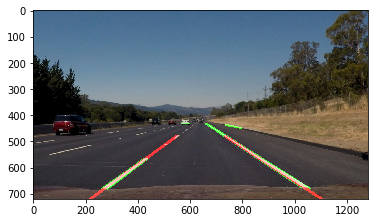

In [5]:
frame = imgproc(mpimg.imread('./test_images/straight_lines2.jpg'))
#apply distortion correction
frame.mtx = mtx
frame.dist = dist
frame.undistort()
#convert to grayscale
frame.grayscale()
# apply gaussian blur
frame.gaussian_blur(5)
# perform edge detection
frame.canny(100,200)
# cut out ROI
imshape = frame.img.shape
vertices = np.array([[(1/7*imshape[1],imshape[0]-40),(2/5*imshape[1], 3/5*imshape[0]), (3/5*imshape[1], 3/5*imshape[0]), (9/10*imshape[1],imshape[0]-40)]], dtype=np.int32)
frame.region_of_interest(vertices)
# select lines from image [hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)]
hough, m_l, b_l, m_r, b_r = frame.hough_lines(1, np.pi/180, 40, 20, 5)
# compute weighted image [weighted_img(img, initial_img, α=0.8, β=1., λ=0.)]
frame.weighted_img(hough, α=0.8, β=1., λ=0.)
# plot image
plt.figure()
plt.imshow(frame.img, cmap='gray')


The hough-lines information that was computed in the previous cell is then used to compute the corner coordinates of the trapezoid that shall be transformed to a rectangle with image coordinates ([[250,0],[1030,0],[1030,720],[250,720]]). The transformation matrix is computed with the function "cv2.getPerspectiveTransform(src, dst)".

In [6]:
#Compute the perspective transformation matrix M
y_min = 460
y_max = imshape[0]
src = ([(y_min-b_l)/m_l,y_min],[(y_min-b_r)/m_r,y_min],[(y_max-b_r)/m_r,y_max],[(y_max-b_l)/m_l,y_max])
src = np.float32(src)
dst = np.float32([[250,0],[1030,0],[1030,720],[250,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
#store transformation matrix in imgproc
frame.M = M
frame.Minv = Minv

## Test perspective transform

The perspective transform is tested in the next cell with several test images. An indication that the transformation is correct is when the left and right lane lines appear to be fairly parallel in the transformed image. This seems to be the case here.

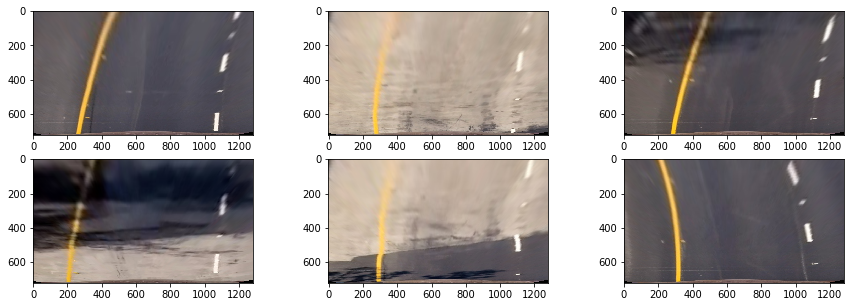

In [7]:
#load test images and perform perspective correction and image transform
images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')

plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img)

## Test thresholding

Next the thresholding function cg_thresh of the imgproc class is tested. This function does the following:
- compute a grayscale image from the undistorted original image and
    - compute the gradient in x-direction from this grayscale image (currently not used)
    - compute gradient magnitude and direction from the grayscale image gradients in x and y direction: mag = np.sqrt(np.square(sobelx)+np.square(sobely)); dirs = np.arctan2(abs_sobely, abs_sobelx)
    - image convolution with sobel kernel is used to compute the gradients (kernel size = 3)
    - apply thresholds to image gradient and magnitude
- compute a hls image from undistorted original image and
    - use "s"-channel from hls image with thresholds
- combine gradient magnitude, direction and hls image information into one enhanced image from which the lane lines can be extracted: combined[((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

The effect of the cg_thresh() function can be seen below with gradient operations in the image in green and hls in blue.

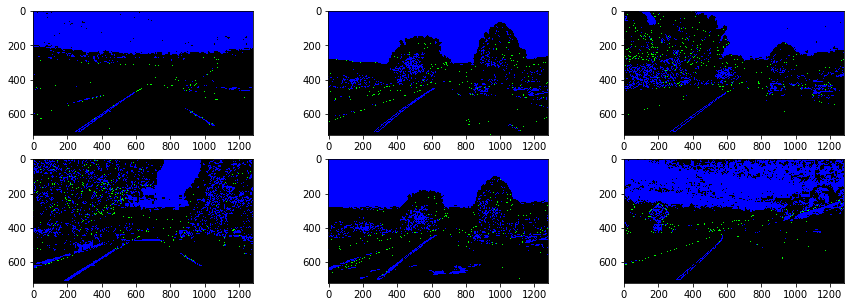

In [8]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.thresh)

In the following the thresholded test images are transformed into top-down view

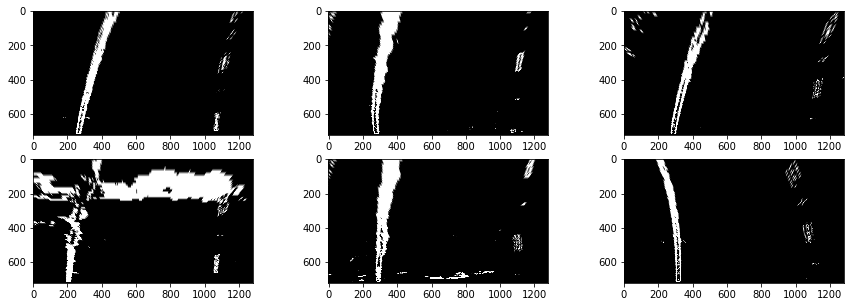

In [9]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame=imgproc(mpimg.imread(img))
    frame.ini_tform(mtx,dist,M,Minv)
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img,cmap='gray')

## Lane detection

### 1. With test images

In this section the complete lane detection process is tested with test images first. For lane detection the images have to be undistorted, thresholded and transformed first. Then the function find_lanes_1() from imgproc is applied.
It has the following sections:
- at the beginning a histogram of the lower half of the image is computed. This histogram is then searched for the two prominent peaks which indicate the starting points of the left and right lane lines. The search is performed between 150 and 400 pixels for the left lane and between 1000 and 1200 pixels for the right lane line.
- Beginning from these starting points the image is searched from bottom to top with 9 search windows that each have a height of 720/9 = 80 pixels and a width of 200 pixels.
- If more than 100 pixels are detected within a search window, the starting point for the next search window is computed as the (integer) mean of the pixel x positions from the previous search window.
- Next, a 2nd order polynomial is fitted through the pixel positions that were identified by the search: self.current_fit[0] = np.polyfit(lefty x self.ym_per_pix, leftx x self.xm_per_pix, 2),... The parameters x,y_m_per_pix are used for transformation from pixels to SI units. 
- This is helpful for the computation of the curvature radius of the lane lines and the distance of the car from the center between the lane lines.
- In the following some plausibility checks are performed on the results of the lane line identification:
    - the difference in curvature radius of the lane lines shall be smaller than 500m
    - the starting points for the lane lines at image bottom shall be between 150 and 400 pixels for the left lane and between 1000 and 1200 pixels for the right lane line.
    - the curvature radius shall be greater than 300m for both lane lines
    - if this is the case the lane detection result is used for the drawing of the lane lines (self.detected=True) and an error counter self.ecnt is reduced by 1.
    - if not the result is not used and the error counter is increased
    - if the result is admitted, it is stored in a buffer list "self.fit_list_l,r" which is used to compute the mean of the last five admissible lane detection results: self.best_fit=np.concatenate((self.fit_list_l.sum(axis=0)/5,self.fit_list_r.sum(axis=0)/5),axis=0)
    - if the error counter reaches 5 the lane identification with the window search is triggered again (self.reaquire=True); if this is not the case - and after the initial lane detection has been performed once - it is sufficient for the analysis of the next image in the pipeline to use the previously computed polynomial function and to search in an evironment of +/-100pixels around this polynomial function

The lines are then drawn with the function draw_lanes():
- First the lane lines are computed for the top-down view with the polynomial coefficients self.best_fit... from the find_lanes_1 function. Then they are transformed into camera view by inverse transformation with self.Minv and merged with the original camera image.
- Also displayed are the enhanced image for lane identification, the top down view and some additional information (radius of curvature, etc).


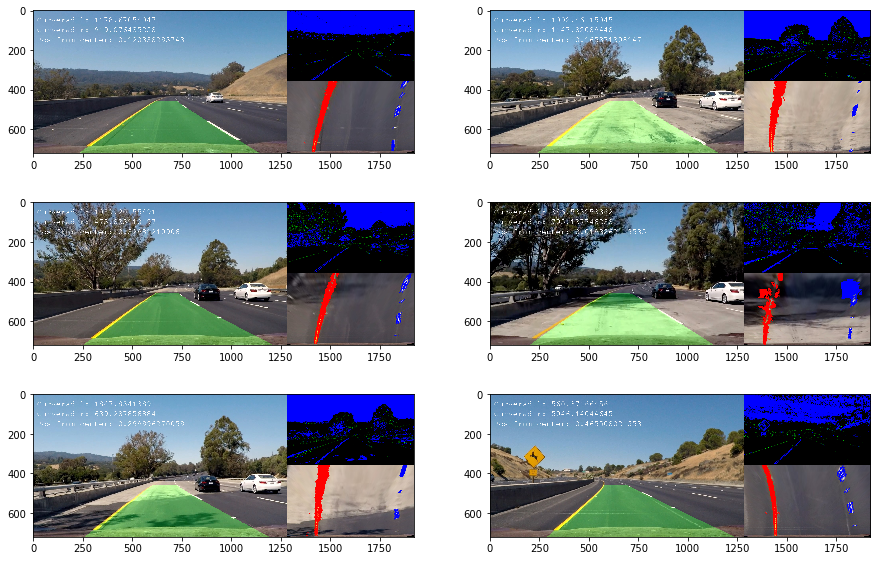

In [10]:
plt.figure(figsize=(15,10))
i=0
for img in images:
    frame=imgproc(mpimg.imread(img))
    frame.ini_tform(mtx,dist,M,Minv)
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    frame.find_lanes_1(pcheck = 0)
    frame.draw_lanes()
    i=i+1
    plt.subplot(3,2,i)
    plt.imshow(frame.img)

### 2. With test videos

the process with videos is the same as described above for test images.

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    frame.load_image(image)
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    frame.find_lanes_1()
    frame.draw_lanes()
    return frame.img

In [13]:
video_output = 'test_videos_output/project_video.mp4'
video_input = VideoFileClip("project_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image)#.subclip(0,5) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:19<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 34s, sys: 4 s, total: 7min 38s
Wall time: 5min 21s


In [14]:
video_output = 'test_videos_output/challenge_video.mp4'
video_input = VideoFileClip("challenge_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image)#.subclip(0,3)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [01:57<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 2min 50s, sys: 1.62 s, total: 2min 51s
Wall time: 1min 59s


## Test different color schemes

In [15]:
def process_image_coltest(image):
    frame.load_image(image)
    frame.undistort()
    frame.col_test(sel_method=8, s_thresh=80, v_thresh=200)
    frame.ptransform()
    return frame.img

In [16]:
video_output = 'test_videos_output/challenge_video_ctest.mp4'
video_input = VideoFileClip("challenge_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image_coltest)#.subclip(0,3)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_ctest.mp4
[MoviePy] Writing video test_videos_output/challenge_video_ctest.mp4


100%|██████████| 485/485 [00:36<00:00, 13.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_ctest.mp4 

CPU times: user 1min 15s, sys: 616 ms, total: 1min 15s
Wall time: 36.8 s
